train loss: 1.01e-02 | test loss: 3.15e-02 | reg: 3.65e+00 : 100%|██| 90/90 [00:26<00:00,  3.45it/s]


fixing (0,0,0) with 1/sqrt(x), r2=0.9971734285354614
fixing (0,0,1) with erfc, r2=0.9413532018661499
fixing (0,1,0) with erfc, r2=0.6161001920700073
fixing (0,1,1) with erfc, r2=0.9993252754211426
fixing (1,0,0) with erfc, r2=0.9992470741271973
fixing (1,0,1) with 1/sqrt(x), r2=0.9027771949768066
fixing (1,1,0) with erfc, r2=0.9280281662940979
fixing (1,1,1) with 1/sqrt(x), r2=0.04381982237100601
fixing (2,0,0) with erfc, r2=0.9997772574424744
fixing (2,1,0) with 1/sqrt(x), r2=0.967512309551239
Discovered Symbolic Formula:
[-10.79*erfc(-1.75*erfc(-0.65*erfc(12.34) - 1.77*erfc(1.32 - 13.44*x_1) - 0.54) - 1.79*erfc(0.01*erfc(24.36) - 0.98 + 1.11/sqrt(x_1 + 0.18)) + 4.44) + 40.61 - 0.03/sqrt(1 - 0.01/sqrt(-0.e-2*erfc(24.36) + 1 - 0.42/sqrt(x_1 + 0.18)) + 0.01/sqrt(0.36*erfc(12.34) + erfc(1.32 - 13.44*x_1) - 0.05))]
Mean Absolute Error (MAE): 0.3922185430054151
Mean Squared Error (MSE): 0.20607015137687246
R-squared (R²): 0.9935292872180029


C:\Users\msi-\AppData\Local\Temp\ipykernel_61032\3784354346.py:110: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


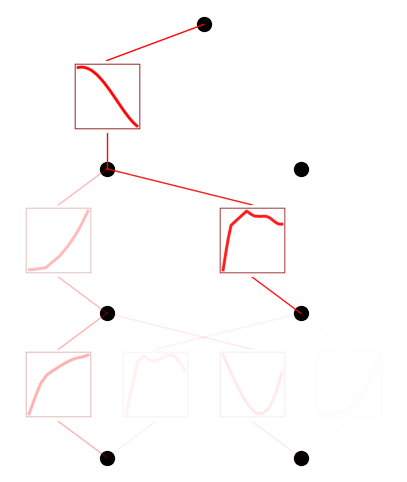

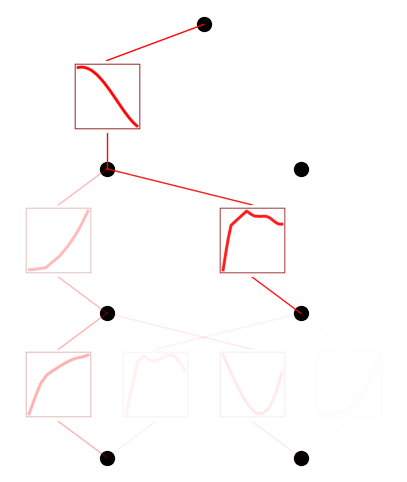

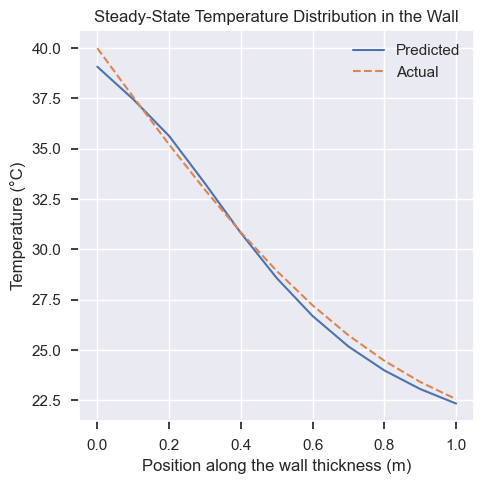

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
from sympy import symbols, sympify
from scipy.special import erfc
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from kan import KAN, add_symbolic
import seaborn as sns

# Parameters
alpha = 2.5e-6
T0 = 20
T1 = 40
L = 1
dx = 0.1
dt = 1800
tMax = 86400
W = 30

# Time and space grid
x = np.arange(0, L + dx, dx)
t = np.arange(dt, tMax + dt, dt)

# Initialize temperature data storage
TemperatureData = np.zeros((len(t), len(x)))

# Compute temperature distribution and store results
for k in range(len(t)):
    TemperatureData[k, :] = T0 + (T1 - T0) * erfc(x / (2 * np.sqrt(alpha * t[k])))

# Prepare the data
x_data = np.array([[x_val, t_val] for t_val in t for x_val in x])
y_data = TemperatureData.flatten()

# Normalize the data
x_mean = np.mean(x_data, axis=0)
x_std = np.std(x_data, axis=0)
y_mean = np.mean(y_data)
y_std = np.std(y_data)

x_data_normalized = (x_data - x_mean) / x_std
y_data_normalized = (y_data - y_mean) / y_std

# Convert to tensors
x_tensor = torch.tensor(x_data_normalized, dtype=torch.float32)
y_tensor = torch.tensor(y_data_normalized, dtype=torch.float32).unsqueeze(1)

# Split dataset into training and test sets
train_size = int(0.8 * len(x_tensor))
test_size = len(x_tensor) - train_size
train_input, test_input = torch.split(x_tensor, [train_size, test_size])
train_label, test_label = torch.split(y_tensor, [train_size, test_size])

# Create the dataset dictionary as expected by KAN
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}

# Add erfc to the symbolic library
add_symbolic('erfc', torch.special.erfc)

# Train the model using the tutorial's approach
model = KAN(width=[2, 2, 2, 1], grid=5, k=3, seed=0)
model.train(dataset, opt="LBFGS", steps=90, lamb=0.001, lamb_entropy=1.0)

# Automatically set activation functions to be symbolic
lib = ['x', '1/sqrt(x)', 'erfc']
model.auto_symbolic(lib=lib)

# Prune the model
model.prune()

# Plot the model
model.plot()
model.plot(mask=True)

# Obtain the symbolic formula and denormalize it
symbolic_formula, x0 = model.symbolic_formula(normalizer=[x_mean, x_std], output_normalizer=[[y_mean], [y_std]])

print("Discovered Symbolic Formula:")
print(symbolic_formula)

# Evaluate the final accuracy of the prediction
x_test = np.array([[x_val, tMax] for x_val in x])  # Use the final time step for testing
x_test_normalized = (x_test - x_mean) / x_std
x_test_tensor = torch.tensor(x_test_normalized, dtype=torch.float32)

predicted_temperature_normalized = model(x_test_tensor).detach().numpy().flatten()
predicted_temperature = predicted_temperature_normalized * y_std + y_mean

# Calculate metrics
mae = mean_absolute_error(TemperatureData[-1, :], predicted_temperature)
mse = mean_squared_error(TemperatureData[-1, :], predicted_temperature)
r2 = r2_score(TemperatureData[-1, :], predicted_temperature)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

# Create output directory for plots
outputDir = 'TemperaturePlots'
if not os.path.exists(outputDir):
    os.makedirs(outputDir)

# 设置全局样式
plt.style.use('seaborn')
sns.set_context("notebook")
sns.set_palette("deep")

# 创建图形和坐标轴
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)

# 绘制预测和实际温度分布
ax.plot(x, predicted_temperature, label='Predicted')
ax.plot(x, TemperatureData[-1, :], label='Actual', linestyle='--')

# 设置标签和标题
ax.set_xlabel('Position along the wall thickness (m)')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Steady-State Temperature Distribution in the Wall')

# 添加图例
ax.legend()

# 添加网格
ax.grid(True)

# 调整布局
plt.tight_layout()

# 保存图形
plt.savefig(f'{outputDir}/PredictedTemperatureDistribution.png', dpi=300)

# 显示图形
plt.show()

C:\Users\msi-\AppData\Local\Temp\ipykernel_61032\1137510372.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


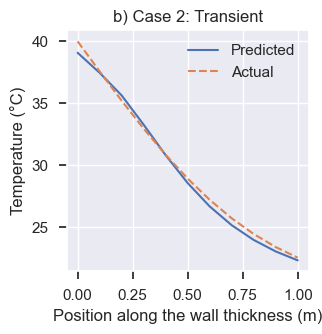

In [5]:

plt.style.use('seaborn')
sns.set_context("notebook")
sns.set_palette("deep")

fig, ax = plt.subplots(figsize=(3.5, 3.5), dpi=100)


ax.plot(x, predicted_temperature, label='Predicted')
ax.plot(x, TemperatureData[-1, :], label='Actual', linestyle='--')


ax.set_xlabel('Position along the wall thickness (m)')
ax.set_ylabel('Temperature (°C)')
ax.set_title('b) Case 2: Transient')


ax.legend()

ax.grid(True)


plt.tight_layout()

plt.savefig(f'{outputDir}/PredictedTemperatureDistribution.png', dpi=300)

plt.show()

In [8]:
print("Discovered Symbolic Formula (Normalized):")
normalized_formula = model.symbolic_formula()[0][0]
normalized_formula

Discovered Symbolic Formula (Normalized):


2.05 - 1.65*erfc(-1.75*erfc(-0.65*erfc(6.09 - 3.54*x_2) - 1.77*erfc(-4.25*x_1 - 5.4) - 0.54) - 1.79*erfc(0.01*erfc(9.6 - 8.35*x_2) - 0.98 + 1.35/sqrt(0.47*x_1 + 1)) + 4.44)

In [9]:
original_formula = normalized_formula * (y_std/x_std) + (y_mean-y_std/x_std * x_mean)
print("Discovered Symbolic Formula (Original):")
print(original_formula)

Discovered Symbolic Formula (Original):
[59.2010258686769 - 34.024397489207*erfc(-1.75*erfc(-0.65*erfc(6.09 - 3.54*x_2) - 1.77*erfc(-4.25*x_1 - 5.4) - 0.54) - 1.79*erfc(0.01*erfc(9.6 - 8.35*x_2) - 0.98 + 1.35/sqrt(0.47*x_1 + 1)) + 4.44)
 15.7083943526499 - 0.000431480916272482*erfc(-1.75*erfc(-0.65*erfc(6.09 - 3.54*x_2) - 1.77*erfc(-4.25*x_1 - 5.4) - 0.54) - 1.79*erfc(0.01*erfc(9.6 - 8.35*x_2) - 0.98 + 1.35/sqrt(0.47*x_1 + 1)) + 4.44)]


In [11]:
# Obtain the symbolic formula and denormalize it
symbolic_formula, x0 = model.symbolic_formula(normalizer=[x_mean, x_std], output_normalizer=[[y_mean], [y_std]])
symbolic_formula

[-10.79*erfc(-1.75*erfc(-0.65*erfc(12.34) - 1.77*erfc(1.32 - 13.44*x_1) - 0.54) - 1.79*erfc(0.01*erfc(24.36) - 0.98 + 1.11/sqrt(x_1 + 0.18)) + 4.44) + 40.61 - 0.03/sqrt(1 - 0.01/sqrt(-0.e-2*erfc(24.36) + 1 - 0.42/sqrt(x_1 + 0.18)) + 0.01/sqrt(0.36*erfc(12.34) + erfc(1.32 - 13.44*x_1) - 0.05))]